In [534]:
import os
import re
import numpy as np
import pandas as pd
import pickle
from typing import Literal
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset_builder, load_dataset, DatasetDict, concatenate_datasets, load_from_disk, Audio
from FlagEmbedding import BGEM3FlagModel

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import zeyrek
import spacy
from spacy.language import Language
from spacy.tokens import Doc, Token

from pydub import AudioSegment
import speech_recognition as sr
from evaluate import load

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import accuracy_score

In [ ]:
nltk.download("stopwords")

spacy.cli.download("en_core_web_md")
spacy.cli.download("fr_core_news_md")
spacy.cli.download("de_core_news_md")
spacy.cli.download("es_core_news_md")

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.8.0/en_core_web_md-3.8.0-py3-none-any.whl (33.5 MB)



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 335.9 kB/s eta 0:00:0000:0100:04
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 2.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 2.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Inspecting & Preprocessing FLEURS Dataset

In [4]:
data_builder = load_dataset_builder("WueNLP/sib-fleurs", "tur_Latn")

data_builder.info.features

{'sentence': Value(dtype='string', id=None),
 'URL': Value(dtype='string', id=None),
 'id': Value(dtype='int32', id=None),
 'domain': Value(dtype='string', id=None),
 'topic': Value(dtype='string', id=None),
 'has_image': Value(dtype='int32', id=None),
 'has_hyperlink': Value(dtype='int32', id=None),
 'fleurs_id': Value(dtype='int32', id=None),
 'filename': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'raw_transcription': Value(dtype='string', id=None),
 'transcription': Value(dtype='string', id=None),
 'num_samples': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'speaker_id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'gender': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'whisper_asr': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'whisper_asr_cer': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 'whisper_asr_wer': Sequence(feature=Va

In [2]:
category_map = {
    0: "science/technology",
    1: "travel",
    2: "politics",
    3: "sports",
    4: "health",
    5: "entertainment",
    6: "geography"
}

language_map = {
    "tur_Latn": "tr-TR",
    "eng_Latn": "en-US",
    "spa_Latn": "es-ES",
    "fra_Latn": "fr-FR",
    "deu_Latn": "de-DE"
}

In [3]:
def remove_cols(dataset, columns_to_remove):
    try:
        return dataset.remove_columns(column_names=columns_to_remove)
    except:
        return dataset

def add_language(dataset, language):
    dataset["language"] = language
    return dataset

def proprocess_topic(dataset):
    topic = dataset["topic"]
    splitted_topic = re.split(r"/", topic)

    new_topics = []
    for element in splitted_topic:
        splitted_element = re.split(r"_", element)
        new_element = " ".join(splitted_element)
        new_topics.append(new_element.lower())
    dataset["topic"] = ", ".join(new_topics)
    return dataset 

def create_hf_ddict(train_split, validation_split, test_split):
    return DatasetDict({"train": train_split,
                        "validation": validation_split,
                        "test": test_split})

In [4]:
load_from_local = True

if load_from_local:
    proc_dataset_dict = load_from_disk("./datasets/processed/proc_dataset_dict")
else:
    # Load datasets
    fleurs_tr_ddict = load_dataset("WueNLP/sib-fleurs", "tur_Latn")
    fleurs_en_ddict = load_dataset("WueNLP/sib-fleurs", "eng_Latn")
    fleurs_sp_ddict = load_dataset("WueNLP/sib-fleurs", "spa_Latn")
    fleurs_fr_ddict = load_dataset("WueNLP/sib-fleurs", "fra_Latn")
    fleurs_du_ddict = load_dataset("WueNLP/sib-fleurs", "deu_Latn")

    fleurs_tr_ddict.save_to_disk("./datasets/raw/fleurs_tr_ddict")
    fleurs_en_ddict.save_to_disk("./datasets/raw/fleurs_en_ddict")
    fleurs_sp_ddict.save_to_disk("./datasets/raw/fleurs_sp_ddict")
    fleurs_fr_ddict.save_to_disk("./datasets/raw/fleurs_fr_ddict")
    fleurs_du_ddict.save_to_disk("./datasets/raw/fleurs_du_ddict")

    dataset_dicts = {"tur_Latn": fleurs_tr_ddict, 
                    "eng_Latn": fleurs_en_ddict, 
                    "spa_Latn": fleurs_sp_ddict, 
                    "fra_Latn": fleurs_fr_ddict, 
                    "deu_Latn": fleurs_du_ddict}
    
    columns_to_remove = ["whisper_asr","whisper_asr_cer","whisper_asr_wer","whisper_asr_translation","seamlessm4t_asr","seamlessm4t_asr_cer","seamlessm4t_asr_wer","seamlessm4t_asr_translation",
                     "index_id","speaker_id","raw_transcription","transcription","has_image","has_hyperlink","id","sentence","URL","num_samples","filename"]

    splits = {"train": [],
            "validation":[],
            "test": []}
    for split in ["train","validation","test"]:
        for language, dataset_dict in dataset_dicts.items():
            dataset_dict[split] = remove_cols(dataset_dict[split], columns_to_remove)
            dataset_dict[split] = dataset_dict[split].map(lambda x: add_language(x, language_map[language]))
            dataset_dict[split] = dataset_dict[split].map(proprocess_topic)
            
            splits[split].append(dataset_dict[split])

    train_split = concatenate_datasets(splits["train"])
    val_split = concatenate_datasets(splits["validation"])
    test_split = concatenate_datasets(splits["test"])

    proc_dataset_dict = create_hf_ddict(train_split,val_split,test_split)

    proc_dataset_dict.save_to_disk("./datasets/processed/proc_dataset_dict")

In [5]:
proc_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 3595
    })
    validation: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 343
    })
    test: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 857
    })
})

In [10]:
total_domains, total_topics, total_categories, total_genders, total_languages, num_audios = {},{},{},{},{},{}

for split in ["train","test","validation"]:
    total_domain = defaultdict(int)
    total_topic = defaultdict(int)
    total_category = defaultdict(int)
    total_gender = defaultdict(int)
    total_language = defaultdict(int)
    num_audio = []
    for row in proc_dataset_dict[split]:
        domain = row["domain"]
        topic = row["topic"]
        category = row["category"]
        language = row["language"]
        total_domain[domain] += 1
        total_topic[topic] += 1
        total_category[category] += 1
        total_language[language] += 1
        num_audio.append(len(row["audio"]))
        for gender in row["gender"]:
            total_gender[gender] += 1
    
    total_domains[split] = total_domain
    total_topics[split] = total_topic
    total_categories[split] = total_category
    total_genders[split] = total_gender
    total_languages[split] = total_language
    num_audios[split] = num_audio

In [11]:
print(total_domains["train"])
print(total_topics["train"])
print("Number of topics: {0}".format(len(total_topics["train"])))
print(total_categories["train"])
print(total_genders["train"])
print(num_audios["train"])

defaultdict(<class 'int'>, {'wikibooks': 1006, 'wikivoyage': 1321, 'wikinews': 1268})
defaultdict(<class 'int'>, {'geography, turkey': 19, 'world war ii, submarines': 19, 'natural wonders, hill stations in india': 10, 'travel, accomodation': 69, 'politics': 176, 'entertainment': 87, 'travel': 402, 'crime': 30, 'travel, archaeology': 5, 'science, radiography': 28, 'how things work, nuclear bomb': 5, 'internet, communication': 15, 'science, distance runner': 34, 'crime and law': 51, 'sports': 283, 'the elements, matter is the stuff around you': 24, 'south america, the amazon': 10, 'science, sensory systems': 15, 'communication theory, uses and gratifications': 5, 'science, earth science': 15, 'economy and business': 10, 'travel, food': 20, 'antartica, travel': 47, 'how things work, lightbulb': 10, 'science, first aid': 18, 'reason to travel, funeral travel': 15, 'disease': 15, 'video, dvd': 20, 'science': 88, 'culture and entertainment': 29, 'international': 10, 'how things work, ice ska

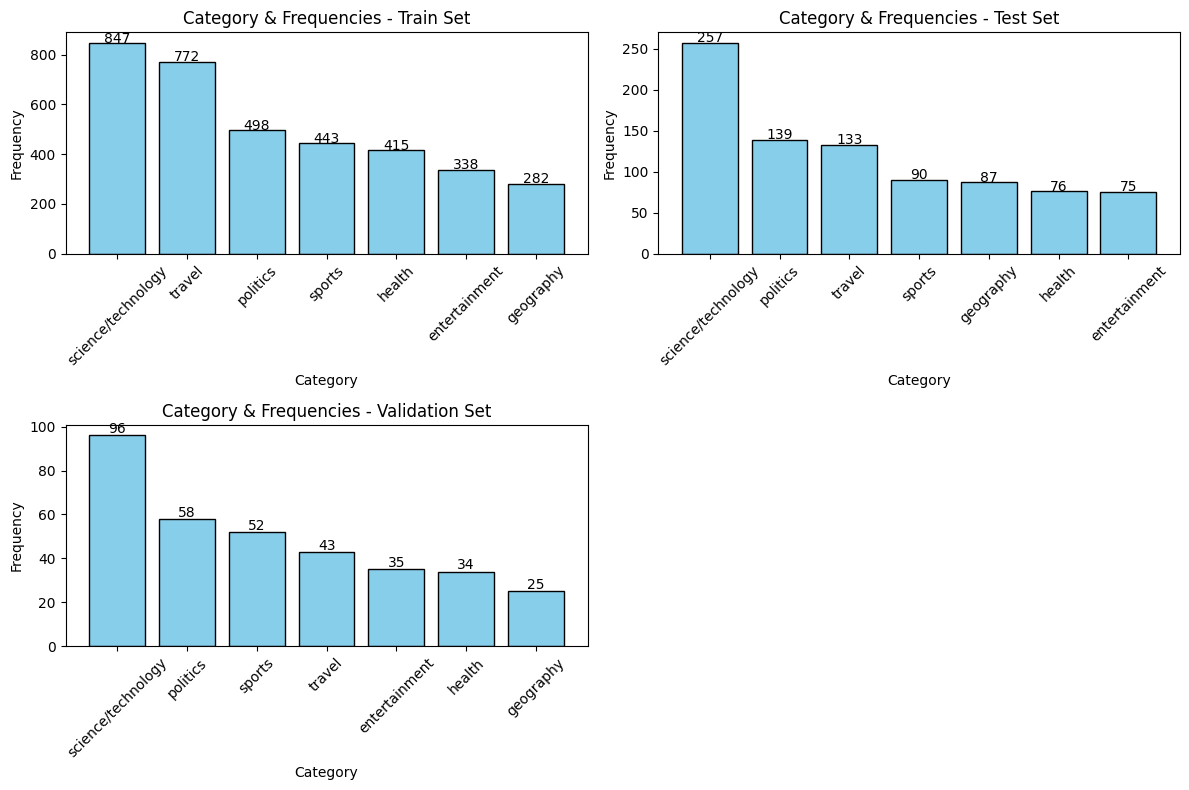

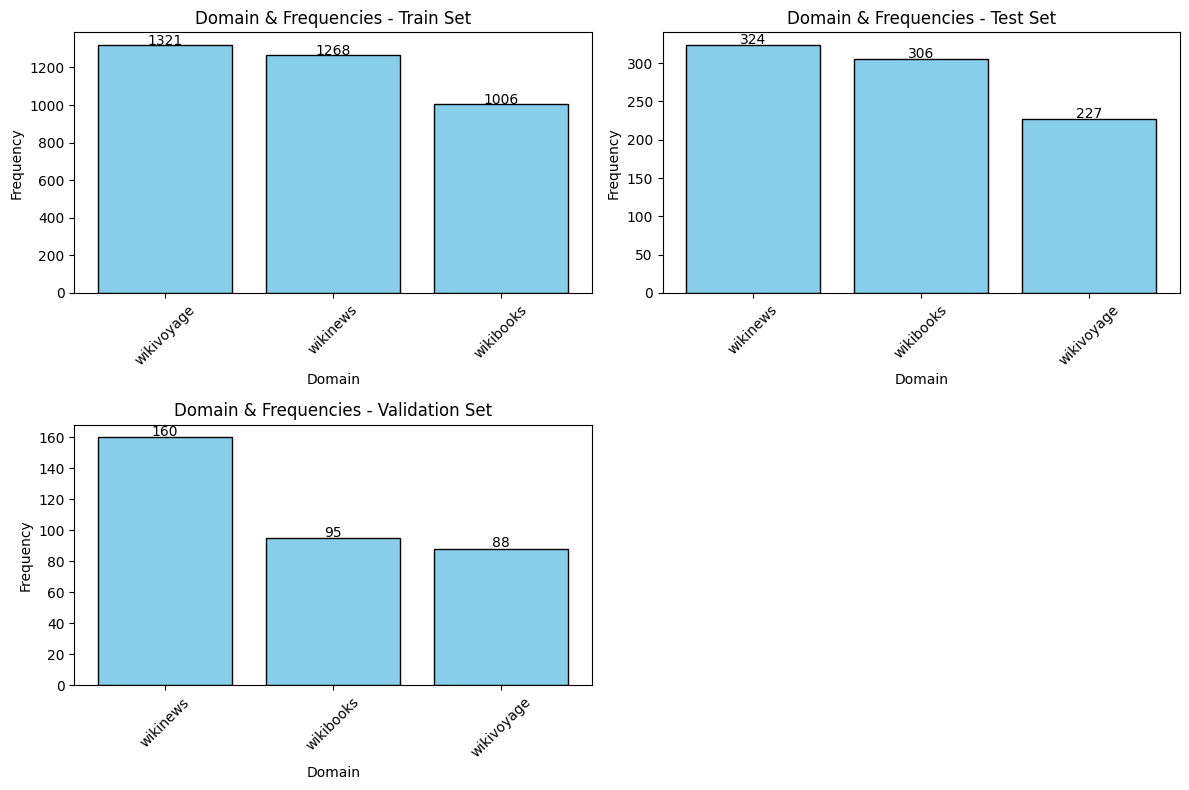

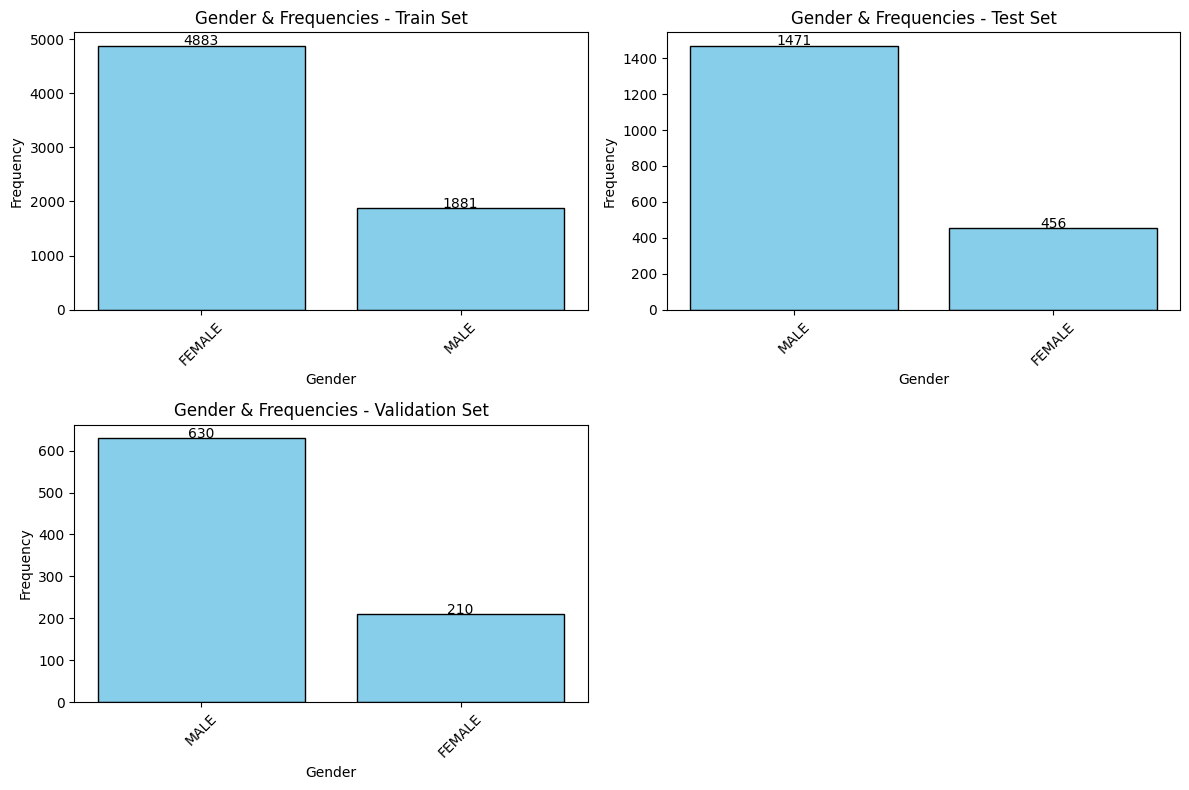

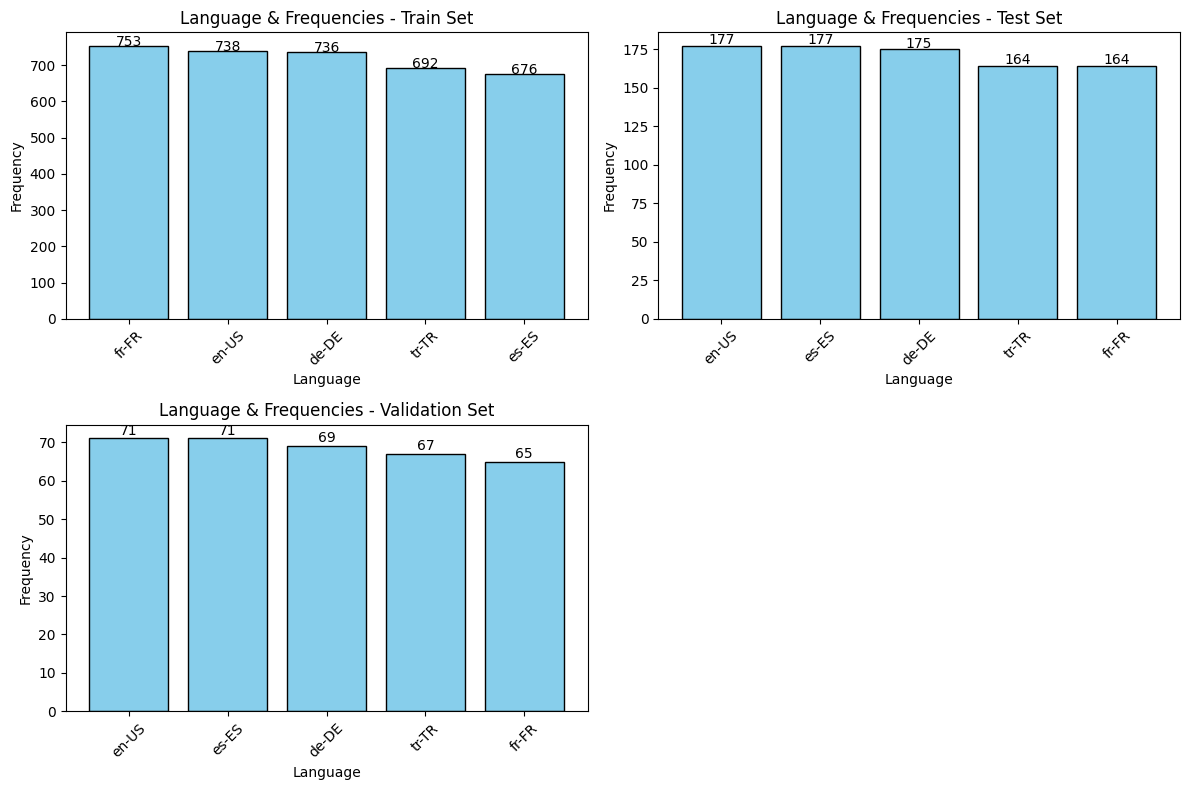

In [12]:
def plot_bar(ax, sorted_data, data_name, split):
    x_vals = list(sorted_data.keys())
    counts = list(sorted_data.values())

    if data_name=="Category":
        x_labels = [category_map[category] for category in x_vals]
        x_positions = range(len(x_vals))
    else:
        x_labels = x_vals
        x_positions = range(len(x_vals))

    # Create bar plot
    ax.bar(x_positions, counts, color='skyblue', edgecolor='black')
    # Set tick positions and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45)

    ax.set_xlabel(data_name)
    ax.set_ylabel("Frequency")
    ax.set_title(f"{data_name} & Frequencies - {split} Set")
    
    # Show values on top of bars
    for i, count in enumerate(counts):
        ax.text(i, count + 1, str(count), ha='center', fontsize=10)

def make_frequency_subgraphs(data=total_categories, data_name: Literal["Category","Domain","Gender","Topic"]="Category"):
    # Sort categories for each dataset
    sorted_train = dict(sorted(data["train"].items(), key=lambda item: item[1], reverse=True))
    sorted_test = dict(sorted(data["test"].items(), key=lambda item: item[1], reverse=True))
    sorted_val = dict(sorted(data["validation"].items(), key=lambda item: item[1], reverse=True))

    # Create a figure with 2x2 subplots
    _, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Plot each dataset in its respective subplot
    plot_bar(axes[0, 0], sorted_train, data_name, "Train")
    plot_bar(axes[0, 1], sorted_test, data_name, "Test")
    plot_bar(axes[1, 0], sorted_val, data_name, "Validation")

    # Hide the bottom-right subplot 
    axes[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

make_frequency_subgraphs(data=total_categories, data_name="Category")
make_frequency_subgraphs(data=total_domains, data_name="Domain")
make_frequency_subgraphs(data=total_genders, data_name="Gender")
make_frequency_subgraphs(data=total_languages, data_name="Language")

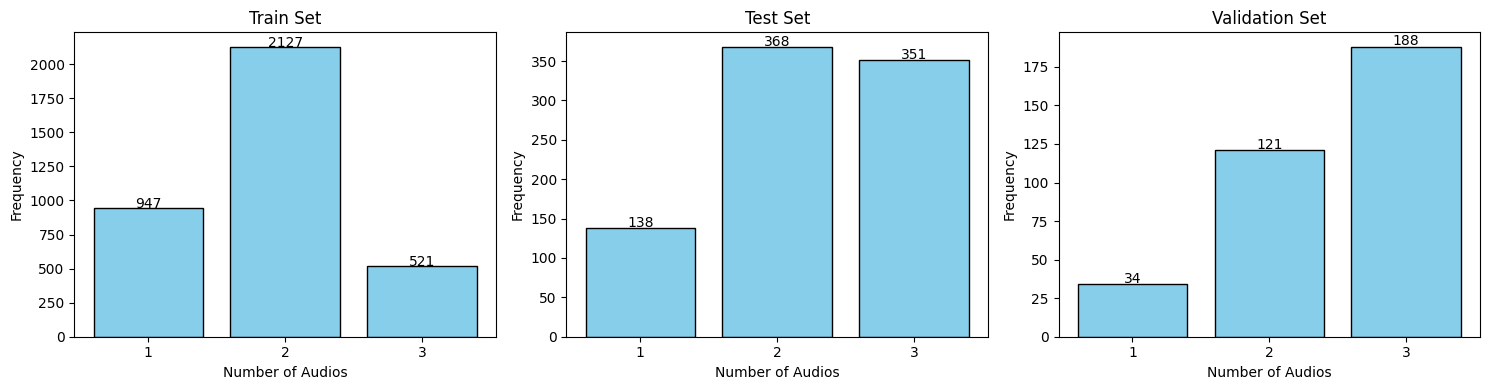

In [13]:
def plot_frequencies(ax, data, title):
    counts = Counter(data)
    vals = list(counts.keys())
    values = counts.values()

    ax.bar(vals, counts.values(), color='skyblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel("Number of Audios")
    ax.set_ylabel("Frequency")
    ax.set_xticks(vals)

    # Show values on top of bars
    for i, v in enumerate(values):
        ax.text(vals[i], v + 1, str(v), ha='center', fontsize=10)

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot for each dataset split
plot_frequencies(axes[0], num_audios["train"], "Train Set")
plot_frequencies(axes[1], num_audios["test"], "Test Set")
plot_frequencies(axes[2], num_audios["validation"], "Validation Set")

# Adjust layout and show
plt.tight_layout()
plt.show()


# Speech Recognition

In [27]:
def transcribe_audio_google(dataset, temp_wav_path: str):
    audio_trans = []
    for sample_audio in dataset["audio"]:
        # Convert NumPy array to bytes
        audio_array = sample_audio["array"]
        fixed_audio_array = (audio_array * 2147483647).astype(np.int32)  # Scale for int32
        audio_bytes = fixed_audio_array.tobytes()

        # Create an AudioSegment
        audio_segment = AudioSegment(
            data=audio_bytes,
            sample_width=4,
            frame_rate=sample_audio["sampling_rate"],
            channels=1)
        
        # Save as a temporary WAV file (needed for speech recognition)
        audio_segment.export(temp_wav_path, format="wav")

        # Initialize speech recognizer & load the temporary WAV file
        recognizer = sr.Recognizer()
        with sr.AudioFile(temp_wav_path) as source:
            audio_data = recognizer.record(source)

        # Perform speech recognition
        try:
            text = recognizer.recognize_google(audio_data,  language=dataset["language"])
        except sr.UnknownValueError:
            text = "N/A"
            print("Speech recognition could not understand the audio")
        except sr.RequestError:
            text = "N/A"
            print("Could not request results from Google Speech Recognition")

        audio_trans.append(text)
        if os.path.exists(temp_wav_path):
                os.remove(temp_wav_path)
        
    dataset["raw_transc_google"] = audio_trans

    return dataset 

def transcribe_audio_hf(dataset, model: str, provider: str):
    asr_model = pipeline("automatic-speech-recognition", 
                         model=model)
    
    audio_trans = []
    for sample_audio in dataset["audio"]:
        text = asr_model(sample_audio["array"])["text"]
        audio_trans.append(text)

    dataset[f"raw_transc_{provider}"]  = audio_trans
    
    return dataset 

def eval_transc(dataset, transcription: str, original_text: str, provider: str):
    wer = load("wer")

    dataset[f"wer_{provider}"] = wer.compute(predictions=[transcription.lower()], 
                                            references=[original_text.lower()])

    return dataset


def sample_by_language(ds, lang, num_samples):
    return ds.filter(lambda x: (x["language"] == lang) & (len(x["audio"]) == 1)).shuffle().select(range(min(len(ds), num_samples)))

In [30]:
splits = ["train"] # "validation","test",
for split in splits:
    temp_ds = proc_dataset_dict[split]

    languages = list(set(temp_ds["language"]))
    samples_per_lang = 3

    demo_dataset_dict = DatasetDict({lang: sample_by_language(temp_ds, lang, samples_per_lang) for lang in languages})

final_demo_dataset_dict = DatasetDict({lang: [] for lang in languages})
for lang, demo_dataset in demo_dataset_dict.items():
    demo_dataset = demo_dataset.map(lambda x: transcribe_audio_google(x, "temp_audio.wav"))
    demo_dataset = demo_dataset.map(lambda x: transcribe_audio_hf(x, "facebook/wav2vec2-base-960h", "meta"))
    demo_dataset = demo_dataset.map(lambda x: transcribe_audio_hf(x, "openai/whisper-tiny", "openai"))

    demo_dataset = demo_dataset.map(lambda x: eval_transc(x, x["raw_transc_google"][0], x["text"], "google"))
    demo_dataset = demo_dataset.map(lambda x: eval_transc(x, x["raw_transc_meta"][0], x["text"], "meta"))
    demo_dataset = demo_dataset.map(lambda x: eval_transc(x, x["raw_transc_openai"][0], x["text"], "openai"))

    final_demo_dataset_dict[lang] = demo_dataset

output = []
for lang, demo_dataset in final_demo_dataset_dict.items():
    output.append({"language": lang, 
                   "wer_google": np.mean(demo_dataset["wer_google"]),
                   "wer_meta": np.mean(demo_dataset["wer_meta"]),
                   "wer_openai": np.mean(demo_dataset["wer_openai"])})

Map:   0%|          | 0/3 [00:00<?, ? examples/s]Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Map:  33%|███▎      | 1/3 [00:01<00:02,  1.05s/ examples]Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Map:  67%|██████▋   | 2/3 [00:01<00:00,  1.29 examples/s]Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be a

language  wer_google  wer_meta  wer_openai
0    fr-FR    0.264646  0.958333    0.240909
1    es-ES    0.137016  1.011693    0.296705
2    en-US    0.081732  0.190250    0.068452
3    de-DE    0.309449  0.981481    0.448758
4    tr-TR    0.190327  1.426928    0.555033

In [31]:
pd.DataFrame(output)

language  wer_google  wer_meta  wer_openai
0    fr-FR    0.264646  0.958333    0.240909
1    es-ES    0.137016  1.011693    0.296705
2    en-US    0.081732  0.190250    0.068452
3    de-DE    0.309449  0.981481    0.448758
4    tr-TR    0.190327  1.426928    0.555033

# Text Analysis & Building spacy NLP Pipelines

In [59]:
with open("stop_words_turkish.txt", "r") as f:
    turkish_stopwords_str = f.read()

# Get stopwords for each language
stopwords_dict = {
    'en-US': set(stopwords.words("english")),
    'tr-TR': set(turkish_stopwords_str.split("\n")),
    'fr-FR': set(stopwords.words("french")),
    'es-ES': set(stopwords.words("spanish")),
    'de-DE': set(stopwords.words("german")),
}

# Print sample stopwords from each language
for lang, words in stopwords_dict.items():
    print(f"{lang.capitalize()} Stopwords Sample: {list(words)[:10]}")

En-us Stopwords Sample: ['himself', 'while', 'that', 'with', 'because', 'each', 'hasn', "isn't", 'yourselves', 'ma']
Tr-tr Stopwords Sample: ['kaçı', 'daha', 'indinde', 'dahi', 'bizden', 'evvelden', 'şura', 'göre', 'gayrı', 'öyle']
Fr-fr Stopwords Sample: ['étions', 'sommes', 'avez', 'ma', 'eut', 'avions', 'fus', 'une', 'ton', 'ayantes']
Es-es Stopwords Sample: ['donde', 'están', 'estuviera', 'habidos', 'estáis', 'tengan', 'ni', 'tuvimos', 'haya', 'muchos']
De-de Stopwords Sample: ['zwischen', 'einigen', 'seines', 'sich', 'wo', 'eine', 'anderen', 'die', 'dasselbe', 'alle']


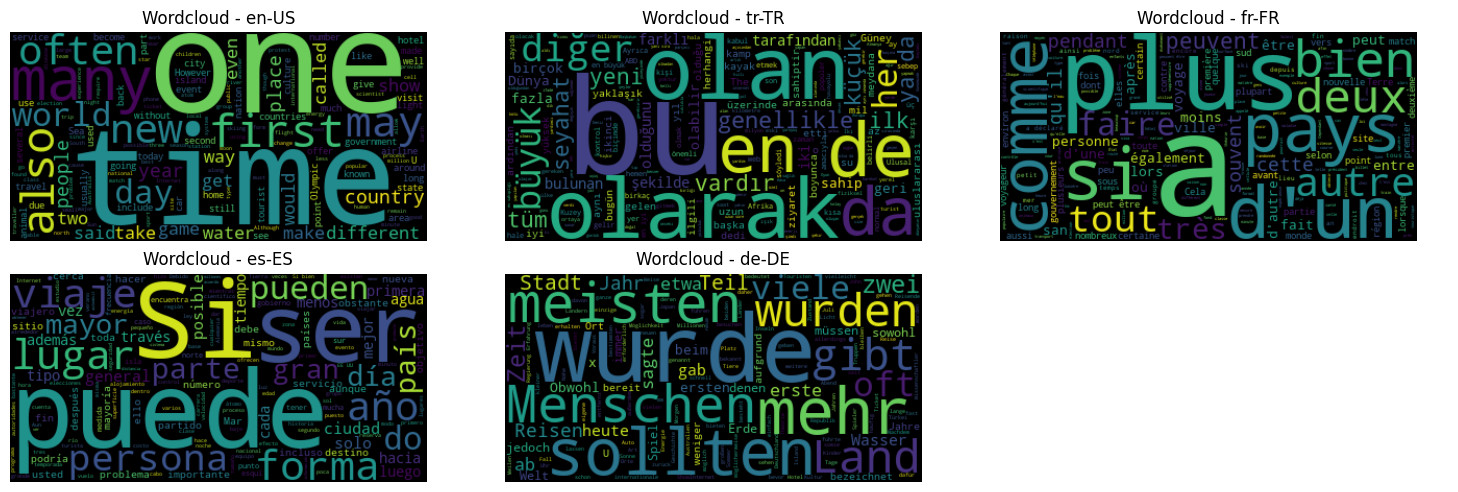

In [60]:
wordclouds = {}
for lang, stopwords_set, in stopwords_dict.items():
    samples = proc_dataset_dict["train"].filter(lambda x: x["language"]==lang)
    full_text = ""
    for sample in samples:
        full_text += sample["text"] + " "

    # Create and generate a word cloud image
    wc = WordCloud(background_color='black', stopwords=stopwords_set).generate(full_text)
    wordclouds[lang] = wc


# Create a 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
axes = axes.flatten()
# Plot word clouds
for i, (lang, wc) in enumerate(wordclouds.items()):
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Wordcloud - {lang}")

# Hide the unused 6th subplot
axes[-1].axis("off")
# Adjust layout
plt.tight_layout()
plt.show()

In [143]:
# List of language models
models = {
    'en-US': "en_core_web_md",
    'fr-FR': "fr_core_news_md",
    'de-DE': "de_core_news_md",
    'es-ES': "es_core_news_md"
}

# Load models while dynamically excluding all components except tokenizer & lemmatizer
nlp_models = {}
for lang, model in models.items():
    nlp = spacy.load(model)  # Load model
    allowed_components = {"tok2vec", "lemmatizer", "tokenizer", 'tagger', 'attribute_ruler', 'morphologizer'}
    all_components = set(nlp.pipe_names)
    exclude_components = list(all_components - allowed_components)
    nlp = spacy.load(model, exclude=exclude_components)
    nlp_models[lang] = nlp 


# Create a blank NLP object for Turkish
tr_nlp = spacy.blank("tr")

@Language.component("custom_tokenizer")
def custom_tokenizer(doc):
    # Tokenize the text based on whitespace
    new_tokens = []
    for token in doc:
        new_tokens.append(token.text)
    
    # Return a new Doc with the tokenized words
    return Doc(doc.vocab, words=new_tokens)

@Language.component("custom_lemmatizer")
def custom_lemmatizer(doc):
    tr_analyzer = zeyrek.MorphAnalyzer()
    for token in doc:
        try:
            lemmas = tr_analyzer.lemmatize(token.text)[0][1]
            if lemmas == []:
                token.lemma_ = token.text
            else:
                token.lemma_ = lemmas[0]
        except:
            token.lemma_ = token.text

    return doc

@Language.component("custom_vectorizer")
def custom_vectorizer(doc):
    embedding_model = SentenceTransformer("msbayindir/legal-text-embedding-turkish-v1")

    embedding = embedding_model.encode(doc.text.lower())
    doc._.set("text_vector", embedding)

    lemmatized_text = " ".join([token.lemma_ for token in doc if token.lemma_.isalnum()]).lower()
    embedding = embedding_model.encode(lemmatized_text)
    doc._.set("lemma_vector", embedding)

    for token in doc:
        text_embedding = embedding_model.encode(token.text.lower())
        token._.set("text_vector", text_embedding)

        lemma_embedding = embedding_model.encode(token.lemma_.lower())
        token._.set("lemma_vector", lemma_embedding)

    return doc

# Add the custom tokenizer to the pipeline
tr_nlp.add_pipe("custom_tokenizer", first=True)
# Add custom lemmatizer to the pipeline
tr_nlp.add_pipe("custom_lemmatizer", after="custom_tokenizer")
# Add vectorizer to the pipeline
Token.set_extension("text_vector", default=None, force=True)
Doc.set_extension("text_vector", default=None, force=True)
Token.set_extension("lemma_vector", default=None, force=True)
Doc.set_extension("lemma_vector", default=None, force=True)
tr_nlp.add_pipe("custom_vectorizer", last=True)

# Add turkish nlp object to nlp_models dictionary
nlp_models["tr-TR"] = tr_nlp

APPENDING RESULT: <(park_Noun)(-)(park:noun_S + a3sg_S + pnon_S + nom_ST)>
APPENDING RESULT: <(Park_Noun_Prop)(-)(park:nounProper_S + a3sg_S + pnon_S + nom_ST)>
APPENDING RESULT: <(,_Punc)(-)(,:puncRoot_ST)>
APPENDING RESULT: <(ala_Noun)(-)(ala:noun_S + a3sg_S + n:p2sg_S + ı:acc_ST)>
APPENDING RESULT: <(alan_Noun)(-)(alan:noun_S + a3sg_S + pnon_S + ı:acc_ST)>
APPENDING RESULT: <(alan_Noun)(-)(alan:noun_S + a3sg_S + ı:p3sg_S + nom_ST)>
APPENDING RESULT: <(almak_Verb)(-)(al:verbRoot_S + an:vPresPart_S + noun_S + a3sg_S + pnon_S + ı:acc_ST)>
APPENDING RESULT: <(almak_Verb)(-)(al:verbRoot_S + an:vPresPart_S + noun_S + a3sg_S + ı:p3sg_S + nom_ST)>
APPENDING RESULT: <(âlâ_Adj)(-)(ala:adjectiveRoot_ST + adjZeroDeriv_S + noun_S + a3sg_S + n:p2sg_S + ı:acc_ST)>
APPENDING RESULT: <(ala_Adj)(-)(ala:adjectiveRoot_ST + adjZeroDeriv_S + noun_S + a3sg_S + n:p2sg_S + ı:acc_ST)>
APPENDING RESULT: <(içermek_Verb)(-)(içer:verbRoot_S + ir:vAor_S + vA3sg_ST)>
APPENDING RESULT: <(içermek_Verb)(-)(içer:verbR

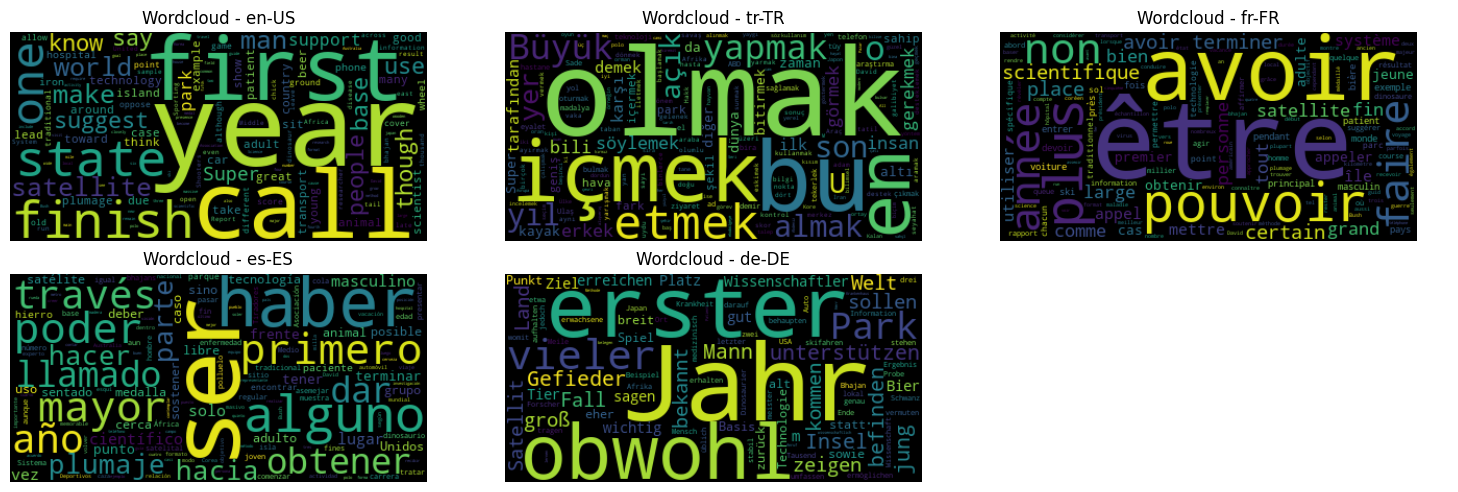

In [128]:
wordclouds = {}
for lang, stopwords_set, in stopwords_dict.items():
    samples = proc_dataset_dict["validation"].filter(lambda x: x["language"]==lang)
    nlp = nlp_models[lang]

    full_text = ""
    for sample in samples:
        doc = nlp(sample["text"])
        full_text += " ".join([token.lemma_ for token in doc if token.text.isalnum()]) + " "

    # Create and generate a word cloud image
    wc = WordCloud(background_color='black', stopwords=stopwords_set).generate(full_text)
    wordclouds[lang] = wc


# Create a 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
axes = axes.flatten()
# Plot word clouds
for i, (lang, wc) in enumerate(wordclouds.items()):
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Wordcloud - {lang}")

# Hide the unused 6th subplot
axes[-1].axis("off")
# Adjust layout
plt.tight_layout()
plt.show()

In [149]:
# Example sentences for Turkish and English
turkish_text = "Bugünlerde kitapları okuyor ve koşuyor."
doc_tr = nlp_models["tr-TR"](turkish_text)
for token in doc_tr:
    if token.is_alpha | token.is_digit:
        print(f"Token: {token.text}, Lemma: {token.lemma_}")
        # print(token._.custom_vector)

print("\n*************\n")

english_text = "Nowadays he read books and runs."
doc_eng = nlp_models["en-US"](english_text)
for token in doc_eng:
    if token.is_alpha | token.is_digit:
        print(f"Token: {token.text}, Lemma: {token.lemma_}")
        # print(token.vector)


APPENDING RESULT: <(bugün_Noun_Time)(-)(bugün:noun_S + ler:a3pl_S + pnon_S + de:loc_ST)>
APPENDING RESULT: <(Kitap_Noun_Prop)(-)(kitap:nounProper_S + a3sg_S + ları:p3pl_S + nom_ST)>
APPENDING RESULT: <(Kitap_Noun_Prop)(-)(kitap:nounProper_S + lar:a3pl_S + pnon_S + ı:acc_ST)>
APPENDING RESULT: <(Kitap_Noun_Prop)(-)(kitap:nounProper_S + lar:a3pl_S + ı:p3sg_S + nom_ST)>
APPENDING RESULT: <(Kitap_Noun_Prop)(-)(kitap:nounProper_S + lar:a3pl_S + ı:p3pl_S + nom_ST)>
APPENDING RESULT: <(kitap_Noun)(-)(kitap:noun_S + a3sg_S + ları:p3pl_S + nom_ST)>
APPENDING RESULT: <(kitap_Noun)(-)(kitap:noun_S + lar:a3pl_S + pnon_S + ı:acc_ST)>
APPENDING RESULT: <(kitap_Noun)(-)(kitap:noun_S + lar:a3pl_S + ı:p3sg_S + nom_ST)>
APPENDING RESULT: <(kitap_Noun)(-)(kitap:noun_S + lar:a3pl_S + ı:p3pl_S + nom_ST)>
APPENDING RESULT: <(okumak_Verb)(-)(ok:verbRoot_VowelDrop_S + uyor:vProgYor_S + vA3sg_ST)>
APPENDING RESULT: <(ve_Conj)(-)(ve:conjRoot_ST)>
APPENDING RESULT: <(koşmak_Verb)(-)(koş:verbRoot_S + uyor:vProgYo

Token: Bugünlerde, Lemma: bugün
Token: kitapları, Lemma: Kitap
Token: okuyor, Lemma: okumak
Token: ve, Lemma: ve
Token: koşuyor, Lemma: koşmak

*************

Token: Nowadays, Lemma: nowadays
Token: he, Lemma: he
Token: read, Lemma: read
Token: books, Lemma: book
Token: and, Lemma: and
Token: runs, Lemma: run


# Preparing Dataset for Modelling

In [203]:
train_df = proc_dataset_dict["train"].to_pandas()[["language","domain","topic","text","category"]]
train_df["split"] = "train"
test_df = proc_dataset_dict["test"].to_pandas()[["language","domain","topic","text","category"]]
test_df["split"] = "test"
val_df = proc_dataset_dict["validation"].to_pandas()[["language","domain","topic","text","category"]]
val_df["split"] = "validation"

data = pd.concat([train_df,test_df,val_df])
data.reset_index(inplace=True, drop=True)

data.head()

language      domain                                    topic  \
0    tr-TR   wikibooks                        geography, turkey   
1    tr-TR   wikibooks                 world war ii, submarines   
2    tr-TR  wikivoyage  natural wonders, hill stations in india   
3    tr-TR  wikivoyage                     travel, accomodation   
4    tr-TR    wikinews                                 politics   

                                                text  category  split  
0  Türkiye'nin üç tarafı denizlerle çevrilidir: B...         6  train  
1  Savaşın başlangıcında çoğunlukla denizin yüzey...         0  train  
2  Ancak, kış aylarında farklı bir güzelliği ve ç...         5  train  
3  Bu oteller günün zenginlerinin ve ünlülerinin ...         5  train  
4  Protestoyu organize edenler Berlin, Köln, Hamb...         2  train

In [204]:
def get_processed_cols(row):
    stopwords = stopwords_dict[row.language]
    nlp = nlp_models[row.language]

    doc = nlp(row.text)
    processed_text = " ".join([token.text for token in doc if ((token.text.isalnum()) | ("'" in token.text)) & (token.text not in stopwords)]).lower()
    processed_lemmas = " ".join([token.lemma_ for token in doc if ((token.lemma_.isalnum()) | ("'" in token.lemma_)) & (token.lemma_ not in stopwords)]).lower()

    return processed_text, processed_lemmas


data["processing_output"] = data.apply(get_processed_cols, axis=1)
data["processed_text"] = data["processing_output"].apply(lambda x: x[0])
data["processed_lemmas"] = data["processing_output"].apply(lambda x: x[1])

APPENDING RESULT: <(Türkiye_Noun_Prop)(-)(türkiye:nounProper_S + a3sg_S + pnon_S + nin:gen_ST)>
APPENDING RESULT: <(Türkiye_Noun_Prop)(-)(türkiye:nounProper_S + a3sg_S + n:p2sg_S + in:gen_ST)>
APPENDING RESULT: <(üç_Num_Card)(-)(üç:numeralRoot_ST)>
APPENDING RESULT: <(taraf_Noun)(-)(taraf:noun_S + a3sg_S + pnon_S + ı:acc_ST)>
APPENDING RESULT: <(taraf_Noun)(-)(taraf:noun_S + a3sg_S + ı:p3sg_S + nom_ST)>
APPENDING RESULT: <(deniz_Noun)(-)(deniz:noun_S + ler:a3pl_S + pnon_S + le:ins_ST)>
APPENDING RESULT: <(çevri_Noun)(-)(çevri:noun_S + a3sg_S + pnon_S + nom_ST + li:with_S + adjectiveRoot_ST + adjZeroDeriv_S + nVerb_S + nPresent_S + nA3sg_S + dir:nCop_ST)>
APPENDING RESULT: <(:_Punc)(-)(::puncRoot_ST)>
APPENDING RESULT: <(batı_Noun)(-)(batı:noun_S + a3sg_S + pnon_S + da:loc_ST)>
APPENDING RESULT: <(Batı_Noun_Prop)(-)(batı:nounProper_S + a3sg_S + pnon_S + da:loc_ST)>
APPENDING RESULT: <(batı_Adj)(-)(batı:adjectiveRoot_ST + adjZeroDeriv_S + noun_S + a3sg_S + pnon_S + da:loc_ST)>
APPENDING 

KeyError: "['processed_output'] not found in axis"

In [205]:
data.drop(columns=["processing_output"], inplace=True)

data.head()

language      domain                                    topic  \
0    tr-TR   wikibooks                        geography, turkey   
1    tr-TR   wikibooks                 world war ii, submarines   
2    tr-TR  wikivoyage  natural wonders, hill stations in india   
3    tr-TR  wikivoyage                     travel, accomodation   
4    tr-TR    wikinews                                 politics   

                                                text  category  split  \
0  Türkiye'nin üç tarafı denizlerle çevrilidir: B...         6  train   
1  Savaşın başlangıcında çoğunlukla denizin yüzey...         0  train   
2  Ancak, kış aylarında farklı bir güzelliği ve ç...         5  train   
3  Bu oteller günün zenginlerinin ve ünlülerinin ...         5  train   
4  Protestoyu organize edenler Berlin, Köln, Hamb...         2  train   

                                      processed_text  \
0  türkiye'nin üç tarafı denizlerle çevrilidir ba...   
1  savaşın başlangıcında denizin yüzeyinde seyaha...   
2  ancak kış aylarında farklı güzelliği çekiciliğ...   
3  bu oteller günün zenginlerinin ünlülerinin kal...   
4  protestoyu organize edenler berlin köln hambur...   

                                    processed_lemmas  
0  türkiye üç taraf deniz çevri batı ege deniz ku...  
1  savaş başlangıç deniz yüzey seyahat etmek rada...  
2  kış ay fark güzel çekici var birçok tepe şehir...  
3  bu otel günü zengin ün kalmak yer zaman kalite...  
4  protesto organize ede berlin köln hamburg hann...

In [206]:
data.to_csv("datasets/processed/prepared_data.csv")

In [213]:
data = pd.read_csv("datasets/processed/prepared_data.csv", index_col=[0])
data.head(3)

language      domain                                    topic  \
0    tr-TR   wikibooks                        geography, turkey   
1    tr-TR   wikibooks                 world war ii, submarines   
2    tr-TR  wikivoyage  natural wonders, hill stations in india   

                                                text  category  split  \
0  Türkiye'nin üç tarafı denizlerle çevrilidir: B...         6  train   
1  Savaşın başlangıcında çoğunlukla denizin yüzey...         0  train   
2  Ancak, kış aylarında farklı bir güzelliği ve ç...         5  train   

                                      processed_text  \
0  türkiye'nin üç tarafı denizlerle çevrilidir ba...   
1  savaşın başlangıcında denizin yüzeyinde seyaha...   
2  ancak kış aylarında farklı güzelliği çekiciliğ...   

                                    processed_lemmas  
0  türkiye üç taraf deniz çevri batı ege deniz ku...  
1  savaş başlangıç deniz yüzey seyahat etmek rada...  
2  kış ay fark güzel çekici var birçok tepe şehir...

# Building Category Prediction Models

https://scikit-learn.org/stable/modules/multiclass.html

https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier

https://www.kaggle.com/code/satishgunjal/binary-multiclass-classification-using-sklearn

https://www.kaggle.com/code/emmanuelfwerr/xgboost-multi-class-classification#XGBoost-Classifier

https://www.kaggle.com/code/syerramilli/ps4e03-multi-class-lightgbm

In [460]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaling_method: Literal["standard","minmax",None]=None):
        self.scaling_method = scaling_method
        self.scaler = None  

    def fit(self, X, y=None):
        """ Fit the appropriate scaler if required """
        if self.scaling_method is None:
            return self
        elif self.scaling_method == "standard":
            self.scaler = StandardScaler()
        elif self.scaling_method == "minmax":
            self.scaler = MinMaxScaler()
        else:
            raise ValueError(f"Unsupported scaling method: {self.scaling_method}")
        self.scaler.fit(X)
        return self 

    def transform(self, X):
        """ Transform the data if scaling is needed """
        if self.scaling_method is not None:
            return self.scaler.transform(X)
        return X  # Return original data if no scaling is required

In [532]:
def construct_sets(lang, data, col_name, target_name, vectorizer_name: Literal["CountVectorizer","TfidfVectorizer"]):
    train_ds = data[(data["language"]==lang) & (data["split"]=="train")][[col_name,target_name]]
    test_ds = data[(data["language"]==lang) & (data["split"]=="test")][[col_name,target_name]]
    val_ds = data[(data["language"]==lang) & (data["split"]=="validation")][[col_name,target_name]]

    X_train, y_train = train_ds[col_name], train_ds[target_name]
    X_test, y_test = test_ds[col_name], test_ds[target_name]
    X_val, y_val = val_ds[col_name], val_ds[target_name]

    if vectorizer_name=="CountVectorizer":
        count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,3))
        X_train = pd.DataFrame(count_vectorizer.fit_transform(X_train.values).toarray(), 
                                columns=count_vectorizer.get_feature_names_out())
        X_test = pd.DataFrame(count_vectorizer.transform(X_test.values).toarray(), 
                                columns=count_vectorizer.get_feature_names_out())
        X_val = pd.DataFrame(count_vectorizer.transform(X_val.values).toarray(), 
                                columns=count_vectorizer.get_feature_names_out())
    elif vectorizer_name=="TfidfVectorizer":
        tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
        X_train = pd.DataFrame(tfidf_vectorizer.fit_transform(X_train.values).toarray(), 
                                columns=tfidf_vectorizer.get_feature_names_out())
        X_test = pd.DataFrame(tfidf_vectorizer.transform(X_test.values).toarray(), 
                                columns=tfidf_vectorizer.get_feature_names_out())
        X_val = pd.DataFrame(tfidf_vectorizer.transform(X_val.values).toarray(), 
                                columns=tfidf_vectorizer.get_feature_names_out())
        
    return X_train,y_train,X_test,y_test,X_val,y_val 

def train_model(clf_and_params, X_train, y_train, **search_cv_params):
    clf = clf_and_params[0]
    pipeline = Pipeline([
        ("scaler", CustomScaler()),
        ("classifier", clf)
    ])

    param_grid = clf_and_params[1]
    grid_search = RandomizedSearchCV(pipeline, param_grid, **search_cv_params)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    return best_model, grid_search.best_params_

def evaluate_accuracy(y_true, y_pred):
    return round(accuracy_score(y_true, y_pred),2)*100


def get_best_pipeline(best_clf, best_params, X_train, y_train):
    scaler_params, clf_params = {}, {}
    for key, value in best_params.items():
        # param_name = key.split("__")[-1]
        if "scaler" in key:
            param_name = key.removeprefix("scaler__")
            scaler_params[param_name] = value
        else:
            param_name = key.removeprefix("classifier__")
            clf_params[param_name] = value

    best_clf.set_params(**clf_params)
    best_pipeline = Pipeline([
        ("scaler", CustomScaler(**scaler_params)),
        ("classifier", best_clf)])
    best_pipeline.fit(X_train, y_train)

    return best_pipeline

In [462]:
MODELS_and_GRID_PARAMS = {
    "MultinomialNB": (
        MultinomialNB(), 
        {"scaler__scaling_method": [None],
         "classifier__alpha": np.arange(0.1,1.1,0.1)}
    ),
    "GaussianNB": (
        GaussianNB(),
        {"scaler__scaling_method": [None]}
    ),
    "KNeighborsClassifier": (
        KNeighborsClassifier(), 
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__n_neighbors": np.arange(5,25,5)}
    ),
    "LinearSVC": (
        LinearSVC(multi_class="ovr", verbose=0, random_state=42), 
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__C": [1,5],
         "classifier__penalty": ["l1","l2"]}
    ),
    "SVC": (
        SVC(verbose=0, random_state=42), 
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__decision_function_shape": ["ovr","ovo"]}
    ),
    "OvR_SVC": (
        OneVsRestClassifier(SVC(kernel="linear", decision_function_shape="ovr", verbose=0, random_state=42)),
        {"scaler__scaling_method": ["standard","minmax"]}
    ),
    "SGDClassifier": (
        SGDClassifier(verbose=0, random_state=42),
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__max_iter": [100,1000],
         "classifier__penalty": ["l1","l2"]}
    ),
    "Perceptron": (
        Perceptron(verbose=0, random_state=42),
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__max_iter": [100,1000],
         "classifier__penalty": ["l1","l2","elasticnet"]}
    ),
    "OvR_Logistic": (
        OneVsRestClassifier(LogisticRegression(solver='lbfgs', verbose=0, random_state=42)),
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__estimator__C": [1,5],
         "classifier__estimator__max_iter": [50,100]}
    ),
    "GradientBoostingClassifier": (
        GradientBoostingClassifier(verbose=0, random_state=42),
        {"scaler__scaling_method": ["standard","minmax",None],
         "classifier__n_estimators": [10,25],
         "classifier__max_depth": [5,10],
         "classifier__learning_rate": [0.001]}
    ),
    "RandomForestClassifier": (
        RandomForestClassifier(verbose=0, random_state=42),
        {"scaler__scaling_method": ["standard","minmax",None],
         "classifier__n_estimators": [10,25],
         "classifier__max_depth": [5,10],
         "classifier__criterion": ["gini","entropy"]}
    ),
    "XGBClassifier": (
        xgb.XGBClassifier(objective='multi:softmax', num_class=7, verbose=-1, random_state=42),
        {"scaler__scaling_method": ["standard","minmax",None],
         "classifier__n_estimators": [10,25],
         "classifier__max_depth": [5,10],
         "classifier__learning_rate": [0.001]}
    ),
    "LGBMClassifier": (
        lgb.LGBMClassifier(boosting_type='gbdt', num_class=7, verbose=-1, random_state=42),
        {"scaler__scaling_method": ["standard","minmax",None],
         "classifier__objective": ["multiclass","multiclassova"],
         "classifier__n_estimators": [10,25],
         "classifier__max_depth": [5,10],
         "classifier__learning_rate": [0.001]}
    ),
}

## Building Models from BoW - texts

In [ ]:
search_cv_params = {"n_iter": 5, "cv": 3, "scoring": "accuracy", "n_jobs": -1}

rows_tfidf = []
rows_count = []
for lang in data["language"].unique().tolist(): #["en-US"]:
    count_train,y_train,count_test,y_test,count_val,y_val = construct_sets(lang, data, col_name="processed_text", target_name="category", vectorizer_name="CountVectorizer")
    tfidf_train,y_train,tfidf_test,y_test,tfidf_val,y_val = construct_sets(lang, data, col_name="processed_text", target_name="category", vectorizer_name="TfidfVectorizer")
    
    for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
        print(f"*** {lang} - count - Modelling started for {clf_name} ***")

        best_model, best_params_ = train_model(clf_and_params, count_train, y_train, **search_cv_params)
        train_preds = best_model.predict(count_train)
        test_preds = best_model.predict(count_test)

        train_accuracy_score = evaluate_accuracy(y_train, train_preds)
        test_accuracy_score = evaluate_accuracy(y_test, test_preds)

        rows_count.append([lang,"count",clf_name,best_params_,train_accuracy_score,test_accuracy_score])
    
    for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
        print(f"*** {lang} - tfidf - Modelling started for {clf_name} ***")

        best_model, best_params_ = train_model(clf_and_params, tfidf_train, y_train, **search_cv_params)
        train_preds = best_model.predict(tfidf_train)
        test_preds = best_model.predict(tfidf_test)

        train_accuracy_score = evaluate_accuracy(y_train, train_preds)
        test_accuracy_score = evaluate_accuracy(y_test, test_preds)

        rows_tfidf.append([lang,"tfidf",clf_name,best_params_,train_accuracy_score,test_accuracy_score])

model_results_from_text = pd.DataFrame(data=rows_count+rows_tfidf, columns=["language","dataset_type","clf","best_params","train_accuracy","test_accuracy"])

In [463]:
best_inds_from_text = model_results_from_text.groupby("language")["test_accuracy"].idxmax().tolist()
bests_df_from_text = model_results_from_text.iloc[best_inds_from_text,:].sort_index()
bests_df_from_text

language dataset_type            clf  \
0     tr-TR        count  MultinomialNB   
13    en-US        count  MultinomialNB   
33    es-ES        count     Perceptron   
46    fr-FR        count     Perceptron   
59    de-DE        count     Perceptron   

                                          best_params  train_accuracy  \
0   {'scaler__scaling_method': None, 'classifier__...            98.0   
13  {'scaler__scaling_method': None, 'classifier__...            99.0   
33  {'scaler__scaling_method': 'standard', 'classi...           100.0   
46  {'scaler__scaling_method': 'standard', 'classi...           100.0   
59  {'scaler__scaling_method': 'standard', 'classi...           100.0   

    test_accuracy  
0            53.0  
13           64.0  
33           61.0  
46           69.0  
59           54.0

In [464]:
best_pipes_from_text = {}
for row in bests_df_from_text.iterrows():
    lang = row[1].language
    best_dataset_type = row[1].dataset_type
    if best_dataset_type=="count":
        X_train,y_train,X_test,y_test,X_val,y_val = construct_sets(lang, data, col_name="processed_text", target_name="category", vectorizer_name="CountVectorizer")
    elif best_dataset_type=="tfidf":
        X_train,y_train,X_test,y_test,X_val,y_val = construct_sets(lang, data, col_name="processed_text", target_name="category", vectorizer_name="TfidfVectorizer")

    best_params = row[1].best_params
    best_clf = MODELS_and_GRID_PARAMS[row[1].clf][0]
    
    best_pipes_from_text[lang] = get_best_pipeline(best_clf, best_params, X_train, y_train)

best_pipes_from_text

{'tr-TR': Pipeline(steps=[('scaler', CustomScaler()),
                 ('classifier', MultinomialNB(alpha=np.float64(0.9)))]),
 'en-US': Pipeline(steps=[('scaler', CustomScaler()),
                 ('classifier', MultinomialNB(alpha=np.float64(0.9)))]),
 'es-ES': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier', Perceptron(penalty='l2', random_state=42))]),
 'fr-FR': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier', Perceptron(penalty='l2', random_state=42))]),
 'de-DE': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier', Perceptron(penalty='l2', random_state=42))])}

### Neural Network

## Building Models from BoW - lemmas

In [467]:
search_cv_params = {"n_iter": 5, "cv": 3, "scoring": "accuracy", "n_jobs": -1}

rows_tfidf = []
rows_count = []
for lang in data["language"].unique().tolist(): #["en-US"]:
    count_train,y_train,count_test,y_test,count_val,y_val = construct_sets(lang, data, col_name="processed_lemmas", target_name="category", vectorizer_name="CountVectorizer")
    tfidf_train,y_train,tfidf_test,y_test,tfidf_val,y_val = construct_sets(lang, data, col_name="processed_lemmas", target_name="category", vectorizer_name="TfidfVectorizer")
    
    for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
        print(f"*** {lang} - count - Modelling started for {clf_name} ***")

        best_model, best_params_ = train_model(clf_and_params, count_train, y_train, **search_cv_params)
        train_preds = best_model.predict(count_train)
        test_preds = best_model.predict(count_test)

        train_accuracy_score = evaluate_accuracy(y_train, train_preds)
        test_accuracy_score = evaluate_accuracy(y_test, test_preds)

        rows_count.append([lang,"count",clf_name,best_params_,train_accuracy_score,test_accuracy_score])
    
    for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
        print(f"*** {lang} - tfidf - Modelling started for {clf_name} ***")

        best_model, best_params_ = train_model(clf_and_params, tfidf_train, y_train, **search_cv_params)
        train_preds = best_model.predict(tfidf_train)
        test_preds = best_model.predict(tfidf_test)

        train_accuracy_score = evaluate_accuracy(y_train, train_preds)
        test_accuracy_score = evaluate_accuracy(y_test, test_preds)

        rows_tfidf.append([lang,"tfidf",clf_name,best_params_,train_accuracy_score,test_accuracy_score])

model_results_from_lemma = pd.DataFrame(data=rows_count+rows_tfidf, columns=["language","dataset_type","clf","best_params","train_accuracy","test_accuracy"])

*** tr-TR - count - Modelling started for MultinomialNB ***
*** tr-TR - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - count - Modelling started for KNeighborsClassifier ***
*** tr-TR - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** tr-TR - count - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - count - Modelling started for SGDClassifier ***
*** tr-TR - count - Modelling started for Perceptron ***
*** tr-TR - count - Modelling started for OvR_Logistic ***
*** tr-TR - count - Modelling started for GradientBoostingClassifier ***
*** tr-TR - count - Modelling started for RandomForestClassifier ***
*** tr-TR - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** tr-TR - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** tr-TR - tfidf - Modelling started for MultinomialNB ***
*** tr-TR - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for KNeighborsClassifier ***
*** tr-TR - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** tr-TR - tfidf - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for SGDClassifier ***
*** tr-TR - tfidf - Modelling started for Perceptron ***
*** tr-TR - tfidf - Modelling started for OvR_Logistic ***
*** tr-TR - tfidf - Modelling started for GradientBoostingClassifier ***
*** tr-TR - tfidf - Modelling started for RandomForestClassifier ***
*** tr-TR - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** tr-TR - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** en-US - count - Modelling started for MultinomialNB ***
*** en-US - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** en-US - count - Modelling started for KNeighborsClassifier ***
*** en-US - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


*** en-US - count - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** en-US - count - Modelling started for SGDClassifier ***
*** en-US - count - Modelling started for Perceptron ***
*** en-US - count - Modelling started for OvR_Logistic ***
*** en-US - count - Modelling started for GradientBoostingClassifier ***
*** en-US - count - Modelling started for RandomForestClassifier ***
*** en-US - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** en-US - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** en-US - tfidf - Modelling started for MultinomialNB ***
*** en-US - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** en-US - tfidf - Modelling started for KNeighborsClassifier ***
*** en-US - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


*** en-US - tfidf - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** en-US - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** en-US - tfidf - Modelling started for SGDClassifier ***
*** en-US - tfidf - Modelling started for Perceptron ***
*** en-US - tfidf - Modelling started for OvR_Logistic ***
*** en-US - tfidf - Modelling started for GradientBoostingClassifier ***
*** en-US - tfidf - Modelling started for RandomForestClassifier ***
*** en-US - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** en-US - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** es-ES - count - Modelling started for MultinomialNB ***
*** es-ES - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - count - Modelling started for KNeighborsClassifier ***
*** es-ES - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** es-ES - count - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - count - Modelling started for SGDClassifier ***
*** es-ES - count - Modelling started for Perceptron ***
*** es-ES - count - Modelling started for OvR_Logistic ***
*** es-ES - count - Modelling started for GradientBoostingClassifier ***
*** es-ES - count - Modelling started for RandomForestClassifier ***
*** es-ES - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** es-ES - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** es-ES - tfidf - Modelling started for MultinomialNB ***
*** es-ES - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - tfidf - Modelling started for KNeighborsClassifier ***
*** es-ES - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** es-ES - tfidf - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - tfidf - Modelling started for SGDClassifier ***
*** es-ES - tfidf - Modelling started for Perceptron ***
*** es-ES - tfidf - Modelling started for OvR_Logistic ***
*** es-ES - tfidf - Modelling started for GradientBoostingClassifier ***
*** es-ES - tfidf - Modelling started for RandomForestClassifier ***
*** es-ES - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** es-ES - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** fr-FR - count - Modelling started for MultinomialNB ***
*** fr-FR - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - count - Modelling started for KNeighborsClassifier ***
*** fr-FR - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** fr-FR - count - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - count - Modelling started for SGDClassifier ***
*** fr-FR - count - Modelling started for Perceptron ***
*** fr-FR - count - Modelling started for OvR_Logistic ***
*** fr-FR - count - Modelling started for GradientBoostingClassifier ***
*** fr-FR - count - Modelling started for RandomForestClassifier ***
*** fr-FR - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** fr-FR - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** fr-FR - tfidf - Modelling started for MultinomialNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** fr-FR - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for KNeighborsClassifier ***
*** fr-FR - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** fr-FR - tfidf - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for SGDClassifier ***
*** fr-FR - tfidf - Modelling started for Perceptron ***
*** fr-FR - tfidf - Modelling started for OvR_Logistic ***
*** fr-FR - tfidf - Modelling started for GradientBoostingClassifier ***
*** fr-FR - tfidf - Modelling started for RandomForestClassifier ***
*** fr-FR - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** fr-FR - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** de-DE - count - Modelling started for MultinomialNB ***
*** de-DE - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - count - Modelling started for KNeighborsClassifier ***
*** de-DE - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** de-DE - count - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - count - Modelling started for SGDClassifier ***
*** de-DE - count - Modelling started for Perceptron ***
*** de-DE - count - Modelling started for OvR_Logistic ***
*** de-DE - count - Modelling started for GradientBoostingClassifier ***
*** de-DE - count - Modelling started for RandomForestClassifier ***
*** de-DE - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** de-DE - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Develop

*** de-DE - tfidf - Modelling started for MultinomialNB ***
*** de-DE - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - tfidf - Modelling started for KNeighborsClassifier ***
*** de-DE - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


*** de-DE - tfidf - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - tfidf - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** de-DE - tfidf - Modelling started for Perceptron ***
*** de-DE - tfidf - Modelling started for OvR_Logistic ***
*** de-DE - tfidf - Modelling started for GradientBoostingClassifier ***
*** de-DE - tfidf - Modelling started for RandomForestClassifier ***
*** de-DE - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** de-DE - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

In [468]:
best_inds_from_lemma = model_results_from_lemma.groupby("language")["test_accuracy"].idxmax().tolist()
bests_df_from_lemma = model_results_from_lemma.iloc[best_inds_from_lemma,:].sort_index()
bests_df_from_lemma

language dataset_type            clf  \
3      tr-TR        count      LinearSVC   
29     es-ES        count      LinearSVC   
59     de-DE        count     Perceptron   
81     en-US        tfidf      LinearSVC   
110    fr-FR        tfidf  SGDClassifier   

                                           best_params  train_accuracy  \
3    {'scaler__scaling_method': 'standard', 'classi...           100.0   
29   {'scaler__scaling_method': 'standard', 'classi...           100.0   
59   {'scaler__scaling_method': 'standard', 'classi...           100.0   
81   {'scaler__scaling_method': 'minmax', 'classifi...           100.0   
110  {'scaler__scaling_method': 'standard', 'classi...           100.0   

     test_accuracy  
3             71.0  
29            70.0  
59            56.0  
81            69.0  
110           71.0

In [469]:
best_pipes_from_lemma = {}
for row in bests_df_from_lemma.iterrows():
    lang = row[1].language
    best_dataset_type = row[1].dataset_type
    if best_dataset_type=="count":
        X_train,y_train,X_test,y_test,X_val,y_val = construct_sets(lang, data, col_name="processed_lemmas", target_name="category", vectorizer_name="CountVectorizer")
    elif best_dataset_type=="tfidf":
        X_train,y_train,X_test,y_test,X_val,y_val = construct_sets(lang, data, col_name="processed_lemmas", target_name="category", vectorizer_name="TfidfVectorizer")

    best_params = row[1].best_params
    best_clf = MODELS_and_GRID_PARAMS[row[1].clf][0]
    
    best_pipes_from_lemma[lang] = get_best_pipeline(best_clf, best_params, X_train, y_train)

best_pipes_from_lemma

{'tr-TR': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier', LinearSVC(C=1, random_state=42))]),
 'es-ES': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier', LinearSVC(C=1, random_state=42))]),
 'de-DE': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier', Perceptron(penalty='l1', random_state=42))]),
 'en-US': Pipeline(steps=[('scaler', CustomScaler(scaling_method='minmax')),
                 ('classifier', LinearSVC(C=1, random_state=42))]),
 'fr-FR': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier',
                  SGDClassifier(max_iter=100, penalty='l1', random_state=42))])}

### Neural Network

## Building Models from Embeddings

In [516]:
embed_and_cat = {}
for ind, row in data.iterrows():
    if row.language not in embed_and_cat.keys():
        embed_and_cat[row.language] = {"train": {"embedding": [], "category": []}, 
                                       "test": {"embedding": [], "category": []}, 
                                       "validation": {"embedding": [], "category": []}
                                    }

    nlp = nlp_models[row.language]
    doc = nlp(row.processed_text)

    if row.language == "tr-TR":
        vector = doc._.text_vector
    else:
        vector = doc.vector

    embed_and_cat[row.language][row.split]["embedding"].append(vector)
    embed_and_cat[row.language][row.split]["category"].append(row.category)

with open("datasets/processed/embed_and_cat.pkl", "wb") as f:
    pickle.dump(embed_and_cat, f)

APPENDING RESULT: <(Türkiye_Noun_Prop)(-)(türkiye:nounProper_S + a3sg_S + pnon_S + nin:gen_ST)>
APPENDING RESULT: <(Türkiye_Noun_Prop)(-)(türkiye:nounProper_S + a3sg_S + n:p2sg_S + in:gen_ST)>
APPENDING RESULT: <(üç_Num_Card)(-)(üç:numeralRoot_ST)>
APPENDING RESULT: <(taraf_Noun)(-)(taraf:noun_S + a3sg_S + pnon_S + ı:acc_ST)>
APPENDING RESULT: <(taraf_Noun)(-)(taraf:noun_S + a3sg_S + ı:p3sg_S + nom_ST)>
APPENDING RESULT: <(deniz_Noun)(-)(deniz:noun_S + ler:a3pl_S + pnon_S + le:ins_ST)>
APPENDING RESULT: <(çevri_Noun)(-)(çevri:noun_S + a3sg_S + pnon_S + nom_ST + li:with_S + adjectiveRoot_ST + adjZeroDeriv_S + nVerb_S + nPresent_S + nA3sg_S + dir:nCop_ST)>
APPENDING RESULT: <(batı_Noun)(-)(batı:noun_S + a3sg_S + pnon_S + da:loc_ST)>
APPENDING RESULT: <(Batı_Noun_Prop)(-)(batı:nounProper_S + a3sg_S + pnon_S + da:loc_ST)>
APPENDING RESULT: <(batı_Adj)(-)(batı:adjectiveRoot_ST + adjZeroDeriv_S + noun_S + a3sg_S + pnon_S + da:loc_ST)>
APPENDING RESULT: <(Ege_Noun_Prop)(-)(ege:nounProper_S + 

In [517]:
with open("datasets/processed/embed_and_cat.pkl", "rb") as f:
    embed_and_cat = pickle.load(f)

In [528]:
search_cv_params = {"n_iter": 5, "cv": 3, "scoring": "accuracy", "n_jobs": -1}

rows = []
for lang in data["language"].unique().tolist(): 
    X_train, y_train = np.array(embed_and_cat[lang]["train"]["embedding"]), np.array(embed_and_cat[lang]["train"]["category"])
    X_test, y_test = np.array(embed_and_cat[lang]["test"]["embedding"]), np.array(embed_and_cat[lang]["test"]["category"])
    X_val, y_val = np.array(embed_and_cat[lang]["validation"]["embedding"]), np.array(embed_and_cat[lang]["validation"]["category"])
    
    for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
        if clf_name not in ["MultinomialNB","GaussianNB"]: # these models do not work with negative values
            print(f"*** {lang} - Modelling started for {clf_name} ***")

            best_model, best_params_ = train_model(clf_and_params, X_train, y_train, **search_cv_params)
            train_preds = best_model.predict(X_train)
            test_preds = best_model.predict(X_test)

            train_accuracy_score = evaluate_accuracy(y_train, train_preds)
            test_accuracy_score = evaluate_accuracy(y_test, test_preds)

            rows.append([lang,clf_name,best_params_,train_accuracy_score,test_accuracy_score])

model_results_from_embedding = pd.DataFrame(data=rows, columns=["language","clf","best_params","train_accuracy","test_accuracy"])

*** tr-TR - Modelling started for KNeighborsClassifier ***
*** tr-TR - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** tr-TR - Modelling started for SVC ***
*** tr-TR - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - Modelling started for SGDClassifier ***
*** tr-TR - Modelling started for Perceptron ***
*** tr-TR - Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** tr-TR - Modelling started for GradientBoostingClassifier ***
*** tr-TR - Modelling started for RandomForestClassifier ***
*** tr-TR - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:23:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:23:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:23:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:23:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** tr-TR - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** en-US - Modelling started for KNeighborsClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** en-US - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** en-US - Modelling started for SVC ***
*** en-US - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** en-US - Modelling started for SGDClassifier ***
*** en-US - Modelling started for Perceptron ***
*** en-US - Modelling started for OvR_Logistic ***
*** en-US - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** en-US - Modelling started for RandomForestClassifier ***
*** en-US - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:24:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:24:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:24:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:24:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** en-US - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** es-ES - Modelling started for KNeighborsClassifier ***
*** es-ES - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** es-ES - Modelling started for SVC ***
*** es-ES - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - Modelling started for SGDClassifier ***
*** es-ES - Modelling started for Perceptron ***
*** es-ES - Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** es-ES - Modelling started for GradientBoostingClassifier ***
*** es-ES - Modelling started for RandomForestClassifier ***
*** es-ES - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** es-ES - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** fr-FR - Modelling started for KNeighborsClassifier ***
*** fr-FR - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** fr-FR - Modelling started for SVC ***
*** fr-FR - Modelling started for OvR_SVC ***
*** fr-FR - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - Modelling started for Perceptron ***
*** fr-FR - Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** fr-FR - Modelling started for GradientBoostingClassifier ***
*** fr-FR - Modelling started for RandomForestClassifier ***
*** fr-FR - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:25:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:25:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:25:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:25:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** fr-FR - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** de-DE - Modelling started for KNeighborsClassifier ***
*** de-DE - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** de-DE - Modelling started for SVC ***
*** de-DE - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - Modelling started for SGDClassifier ***
*** de-DE - Modelling started for Perceptron ***
*** de-DE - Modelling started for OvR_Logistic ***
*** de-DE - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** de-DE - Modelling started for RandomForestClassifier ***
*** de-DE - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:26:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:26:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:26:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:26:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** de-DE - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

In [529]:
best_inds_from_embedding = model_results_from_embedding.groupby("language")["test_accuracy"].idxmax().tolist()
bests_df_from_embedding = model_results_from_embedding.iloc[best_inds_from_embedding,:].sort_index()
bests_df_from_embedding

language           clf                                        best_params  \
6     tr-TR  OvR_Logistic  {'scaler__scaling_method': 'minmax', 'classifi...   
13    en-US           SVC  {'scaler__scaling_method': 'minmax', 'classifi...   
28    es-ES  OvR_Logistic  {'scaler__scaling_method': 'minmax', 'classifi...   
36    fr-FR       OvR_SVC               {'scaler__scaling_method': 'minmax'}   
50    de-DE  OvR_Logistic  {'scaler__scaling_method': 'minmax', 'classifi...   

    train_accuracy  test_accuracy  
6             98.0           46.0  
13            91.0           68.0  
28            97.0           80.0  
36            95.0           79.0  
50            86.0           69.0

In [533]:
best_pipes_from_embeddding = {}
for row in bests_df_from_embedding.iterrows():
    lang = row[1].language

    X_train, y_train = np.array(embed_and_cat[lang]["train"]["embedding"]), np.array(embed_and_cat[lang]["train"]["category"])
    X_test, y_test = np.array(embed_and_cat[lang]["test"]["embedding"]), np.array(embed_and_cat[lang]["test"]["category"])
    X_val, y_val = np.array(embed_and_cat[lang]["validation"]["embedding"]), np.array(embed_and_cat[lang]["validation"]["category"])

    best_params = row[1].best_params
    best_clf = MODELS_and_GRID_PARAMS[row[1].clf][0]
    
    best_pipes_from_embeddding[lang] = get_best_pipeline(best_clf, best_params, X_train, y_train)

best_pipes_from_embeddding

/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

{'tr-TR': Pipeline(steps=[('scaler', CustomScaler(scaling_method='minmax')),
                 ('classifier',
                  OneVsRestClassifier(estimator=LogisticRegression(C=1,
                                                                   max_iter=50,
                                                                   random_state=42)))]),
 'en-US': Pipeline(steps=[('scaler', CustomScaler(scaling_method='minmax')),
                 ('classifier', SVC(random_state=42, verbose=0))]),
 'es-ES': Pipeline(steps=[('scaler', CustomScaler(scaling_method='minmax')),
                 ('classifier',
                  OneVsRestClassifier(estimator=LogisticRegression(C=1,
                                                                   max_iter=50,
                                                                   random_state=42)))]),
 'fr-FR': Pipeline(steps=[('scaler', CustomScaler(scaling_method='minmax')),
                 ('classifier',
                  OneVsRestClassifier(estimato

### Neural Network

## Building One4All Languages Model with multilingual embedding model

In [ ]:
ml_embedding_model = BGEM3FlagModel('BAAI/bge-m3',  
                                    use_fp16=True) # Note: Setting use_fp16 to True speeds up computation with a slight performance degradation

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 35889.65it/s]


In [542]:
embed_and_cat_multilingual = {}
for ind, row in data.iterrows():
    if row.language not in embed_and_cat_multilingual.keys():
        embed_and_cat_multilingual[row.language] = {"train": {"embedding": [], "category": []}, 
                                                    "test": {"embedding": [], "category": []}, 
                                                    "validation": {"embedding": [], "category": []}
                                                    }

    embedding_vector = ml_embedding_model.encode(row.processed_text, 
                                                max_length=8192,
                                                return_dense=True,
                                                return_sparse=False,
                                                return_colbert_vecs=False)["dense_vecs"]

    embed_and_cat_multilingual[row.language][row.split]["embedding"].append(embedding_vector)
    embed_and_cat_multilingual[row.language][row.split]["category"].append(row.category)

with open("datasets/processed/embed_and_cat_multilingual.pkl", "wb") as f:
    pickle.dump(embed_and_cat_multilingual, f)

In [543]:
with open("datasets/processed/embed_and_cat_multilingual.pkl", "rb") as f:
    embed_and_cat_multilingual = pickle.load(f)

In [547]:
search_cv_params = {"n_iter": 5, "cv": 3, "scoring": "accuracy", "n_jobs": -1}

X_train, y_train, X_test, y_test, X_val, y_val  = [], [], [], [], [], []
for lang, split_dict in embed_and_cat_multilingual.items(): 
    X_train += split_dict["train"]["embedding"]
    y_train += split_dict["train"]["category"]
    X_test += split_dict["test"]["embedding"]
    y_test += split_dict["test"]["category"]
    X_val += split_dict["validation"]["embedding"]
    y_val += split_dict["validation"]["category"]
X_train, y_train, X_test, y_test, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), np.array(X_val), np.array(y_val)

rows = []
for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
    if clf_name not in ["MultinomialNB","GaussianNB"]: # these models do not work with negative values
        print(f"*** Modelling started for {clf_name} ***")

        best_model, best_params_ = train_model(clf_and_params, X_train, y_train, **search_cv_params)
        train_preds = best_model.predict(X_train)
        test_preds = best_model.predict(X_test)

        train_accuracy_score = evaluate_accuracy(y_train, train_preds)
        test_accuracy_score = evaluate_accuracy(y_test, test_preds)

        rows.append([clf_name,best_params_,train_accuracy_score,test_accuracy_score])

model_results_from_ml_embedding = pd.DataFrame(data=rows, columns=["clf","best_params","train_accuracy","test_accuracy"])

*** Modelling started for KNeighborsClassifier ***
*** Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** Modelling started for SGDClassifier ***
*** Modelling started for Perceptron ***
*** Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** Modelling started for GradientBoostingClassifier ***
*** Modelling started for RandomForestClassifier ***
*** Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

In [551]:
model_results_from_ml_embedding

clf  \
0         KNeighborsClassifier   
1                    LinearSVC   
2                          SVC   
3                      OvR_SVC   
4                SGDClassifier   
5                   Perceptron   
6                 OvR_Logistic   
7   GradientBoostingClassifier   
8       RandomForestClassifier   
9                XGBClassifier   
10              LGBMClassifier   

                                          best_params  train_accuracy  \
0   {'scaler__scaling_method': 'minmax', 'classifi...           100.0   
1   {'scaler__scaling_method': 'minmax', 'classifi...           100.0   
2   {'scaler__scaling_method': 'standard', 'classi...           100.0   
3                {'scaler__scaling_method': 'minmax'}           100.0   
4   {'scaler__scaling_method': 'standard', 'classi...           100.0   
5   {'scaler__scaling_method': 'standard', 'classi...           100.0   
6   {'scaler__scaling_method': 'minmax', 'classifi...           100.0   
7   {'scaler__scaling_method': None, 'classifier__...            44.0   
8   {'scaler__scaling_method': None, 'classifier__...            98.0   
9   {'scaler__scaling_method': None, 'classifier__...            97.0   
10  {'scaler__scaling_method': 'standard', 'classi...            36.0   

    test_accuracy  
0            81.0  
1            82.0  
2            88.0  
3            81.0  
4            84.0  
5            81.0  
6            83.0  
7            35.0  
8            56.0  
9            47.0  
10           35.0

In [555]:
best_inds_from_ml_embedding = model_results_from_ml_embedding["test_accuracy"].idxmax()
clf = model_results_from_ml_embedding.loc[best_inds_from_ml_embedding,"clf"]
best_params = model_results_from_ml_embedding.loc[best_inds_from_ml_embedding,"best_params"]
best_clf = MODELS_and_GRID_PARAMS[clf][0]

clf, best_params

('SVC',
 {'scaler__scaling_method': 'standard',
  'classifier__decision_function_shape': 'ovr'})

In [556]:
X_train, y_train, X_test, y_test, X_val, y_val  = [], [], [], [], [], []
for lang, split_dict in embed_and_cat_multilingual.items(): 
    X_train += split_dict["train"]["embedding"]
    y_train += split_dict["train"]["category"]
    X_test += split_dict["test"]["embedding"]
    y_test += split_dict["test"]["category"]
    X_val += split_dict["validation"]["embedding"]
    y_val += split_dict["validation"]["category"]
X_train, y_train, X_test, y_test, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), np.array(X_val), np.array(y_val)

best_pipe_from_ml_embeddding = get_best_pipeline(best_clf, best_params, X_train, y_train)
best_pipe_from_ml_embeddding

Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                ('classifier', SVC(random_state=42, verbose=0))])

In [560]:
rows = []
for lang, split_dict in embed_and_cat_multilingual.items(): 
    X_train = split_dict["train"]["embedding"]
    y_train = split_dict["train"]["category"]
    X_test = split_dict["test"]["embedding"]
    y_test = split_dict["test"]["category"]
    X_val = split_dict["validation"]["embedding"]
    y_val = split_dict["validation"]["category"]
    X_train, y_train, X_test, y_test, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), np.array(X_val), np.array(y_val)

    train_preds = best_pipe_from_ml_embeddding.predict(X_train)
    test_preds = best_pipe_from_ml_embeddding.predict(X_test)
    val_preds = best_pipe_from_ml_embeddding.predict(X_val)

    train_accuracy_score = evaluate_accuracy(y_train, train_preds)
    test_accuracy_score = evaluate_accuracy(y_test, test_preds)
    val_accuracy_score = evaluate_accuracy(y_val, val_preds)

    rows.append([lang,train_accuracy_score,test_accuracy_score,val_accuracy_score])

best_pipe_perf_by_lang = pd.DataFrame(data=rows, columns=["lang","train_accuracy","test_accuracy","val_accuracy"])

In [561]:
best_pipe_perf_by_lang

lang  train_accuracy  test_accuracy  val_accuracy
0  tr-TR           100.0           88.0          91.0
1  en-US           100.0           89.0          87.0
2  es-ES           100.0           86.0          87.0
3  fr-FR           100.0           87.0          89.0
4  de-DE           100.0           89.0          84.0

### Neural Network

# Improvement Areas:

- Hyperparameter tuning can be done on larger grids.
- GridSearchCV, Optuna can be used in hyperparameter tuning.
- Dimension of embedding models can be increased to get better performance. (i.e. trying large spacy models or different embedding models in HuggingFace etc.)